# Up/Down decon with stochastic gradient algorithms for single virtual source - Salt Model

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import xarray as xr
import torch
import torchvision
import torch.nn as nn
import pylops_gpu

from scipy.sparse import csr_matrix, vstack
from scipy.signal import filtfilt,convolve
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc
from torch.autograd import gradcheck
from pylops_gpu.utils.backend import device
from torch.nn import MSELoss
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Dataset, DataLoader

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.tapers               import *
from pylops.utils.signalprocessing     import convmtx
from pylops.basicoperators             import *
from pylops.signalprocessing import *
from pylops.waveeqprocessing.wavedecomposition import *
from pylops.waveeqprocessing.oneway import PhaseShift
from pylops.waveeqprocessing.mdd import MDC, MDD
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import *

from stochmdd.stochmdd import MDDminibatch
from stochmdd.steepest import *

## Parameters

In [2]:
inputdir = '../../data/'

jtdata = 2 # shift to apply to the Mck pup

datakind = 'marchenko' # 'marchenko' or 'mdcmodelled'
jt = 0 # shift to apply to R to allow alignment with Rest (obsolete)

nr = 151
ivs = 75 # virtual source for analysis and visualization

niter = 20 # MDD iterations

# 1.
#nepochs = niter
#batch_size = 21

# 2.
#nepochs = niter
#batch_size = 11

# 3.
nepochs = niter
batch_size = 32

# 4.
#nepochs = niter
#batch_size = 64

## Data preparation

In [3]:
ds_mko = xr.open_dataset(os.path.join(inputdir, 'S_mko.nc'))
print("S-MKO REDATUMED WAVEFIELDS: {}".format(ds_mko.keys()))

S-MKO REDATUMED WAVEFIELDS: KeysView(<xarray.Dataset>
Dimensions:  (t: 2001, x_r: 201, x_vs: 151)
Coordinates:
  * t        (t) float64 0.0 0.004 0.008 0.012 0.016 ... 7.988 7.992 7.996 8.0
  * x_r      (x_r) int64 4000 4040 4080 4120 4160 ... 11880 11920 11960 12000
  * x_vs     (x_vs) int64 6000 6020 6040 6060 6080 ... 8920 8940 8960 8980 9000
Data variables:
    g_plus   (t, x_r, x_vs) float64 ...
    g_minus  (t, x_r, x_vs) float64 ...
Attributes:
    dt:          0.004
    dx_r:        40
    dx_vs:       20
    units_t:     s
    units_x_r:   m
    units_x_vs:  m)


In [4]:
# Receivers
r = ds_mko.coords['x_vs'].values
nr = r.size
dr = r[1]-r[0]

# Sources
s = ds_mko.coords['x_r'].values
ns = s.size
ds = s[1]-s[0]

# Time
t = ds_mko.coords['t'].values
nt = t.size
dt = t[1]-t[0]

# Wavelet
wav, _, wav_c = ricker(t[0:51], 20)
wav_c = np.argmax(wav)

In [5]:
# Data (rescale to get values around 1)
pdown = ds_mko['g_plus'].values * 2000
pup = ds_mko['g_minus'].values * 2000

In [6]:
pup.max(), pdown.max()

(0.16284288178508466, 4.025022115941713)

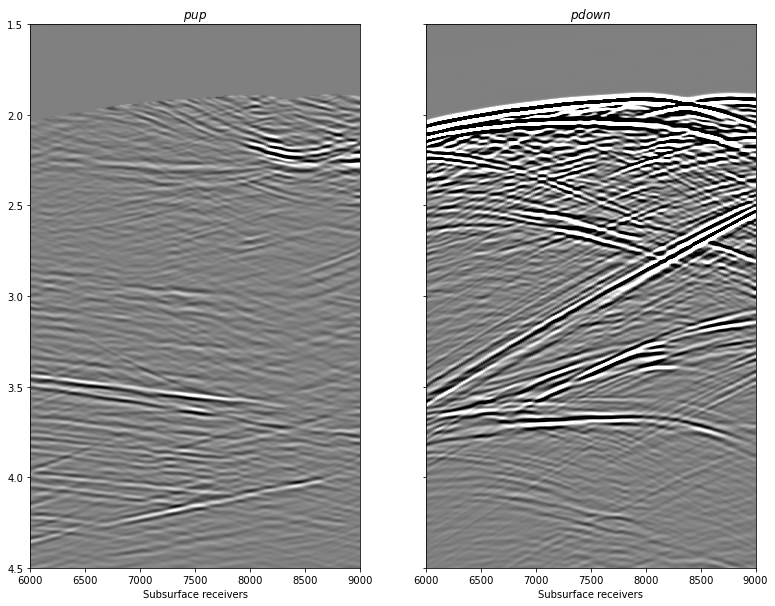

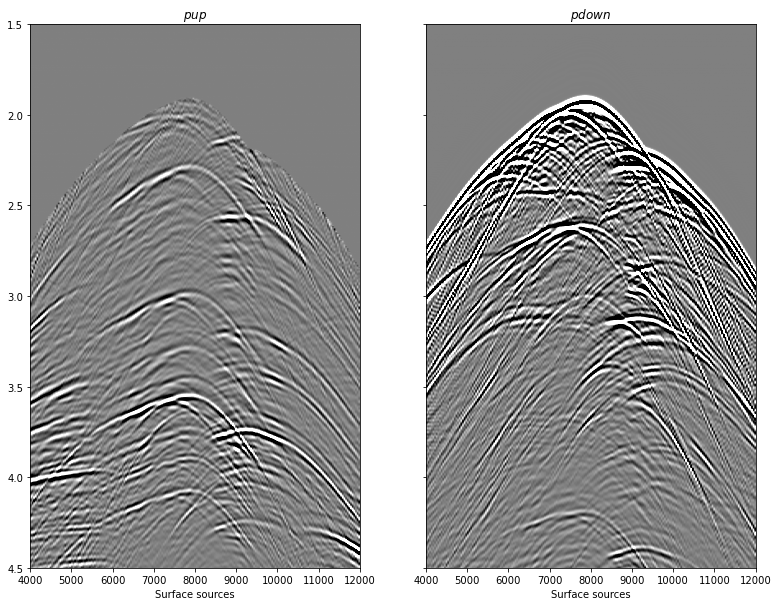

In [7]:
# Pad data with zero at the end (to avoid wrap around)
npad = 5
pdown = np.pad(pdown, ((0, npad), (0, 0), (0, 0)))
ntpad = pdown.shape[0]
tpad = np.arange(ntpad) * dt

pup = np.pad(pup, ((0, npad+jtdata), (0, 0), (0, 0))) 
pup = pup[jtdata:]

clip = 0.005
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(13, 10))
axs[0].imshow(pup[:, ns//2], cmap='gray', vmin=-clip*np.abs(pdown).max(), vmax=clip*np.abs(pdown).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
axs[0].set_title(r'$pup$')
axs[0].set_xlabel('Subsurface receivers')
axs[0].axis('tight')
axs[1].imshow(pdown[:, ns//2], cmap='gray', vmin=-clip*np.abs(pdown).max(), vmax=clip*np.abs(pdown).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
axs[1].set_title(r'$pdown$')
axs[1].set_xlabel('Subsurface receivers')
axs[1].axis('tight')
axs[1].set_ylim(4.5, 1.5);

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(13, 10))
axs[0].imshow(pup[:, :, nr//2], cmap='gray', vmin=-clip*np.abs(pdown).max(), vmax=clip*np.abs(pdown).max(),
              extent = (s[0], s[-1], t[-1], t[0]))
axs[0].set_title(r'$pup$')
axs[0].set_xlabel('Surface sources')
axs[0].axis('tight')
axs[1].imshow(pdown[:, :, nr//2], cmap='gray', vmin=-clip*np.abs(pdown).max(), vmax=clip*np.abs(pdown).max(),
              extent = (s[0], s[-1], t[-1], t[0]))
axs[1].set_xlabel('Surface sources')
axs[1].set_title(r'$pdown$')
axs[1].axis('tight')
axs[1].set_ylim(4.5, 1.5);

In [8]:
# FD Local reflection response @ z=4400m, f_max -> 40Hz
ds_R = xr.open_dataset(os.path.join(inputdir, 'R_FD_40Hz_z4400.nc'))
print("R FINITE DIFFERENCES 60Hz : {}".format(ds_R.keys()))

Rorig = ds_R['R'].values
Rorig = np.pad(Rorig, ((0, npad), (0, 0), (0, 0)))

tracelim = (1.5, -1.5)

R FINITE DIFFERENCES 60Hz : KeysView(<xarray.Dataset>
Dimensions:  (t: 2001, x_vr: 151, x_vs: 151)
Coordinates:
  * t        (t) float64 0.0 0.004 0.008 0.012 0.016 ... 7.988 7.992 7.996 8.0
  * x_vr     (x_vr) int64 6000 6020 6040 6060 6080 ... 8920 8940 8960 8980 9000
  * x_vs     (x_vs) int64 6000 6020 6040 6060 6080 ... 8920 8940 8960 8980 9000
Data variables:
    R        (t, x_vr, x_vs) float64 ...
Attributes:
    dt:          0.004
    dx_r:        20
    dx_vs:       20
    units_t:     s
    units_x_vr:  m
    units_x_vs:  m)


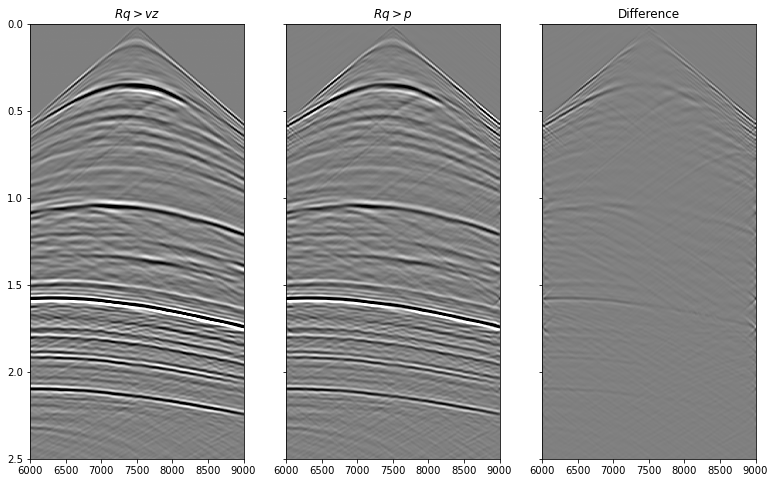

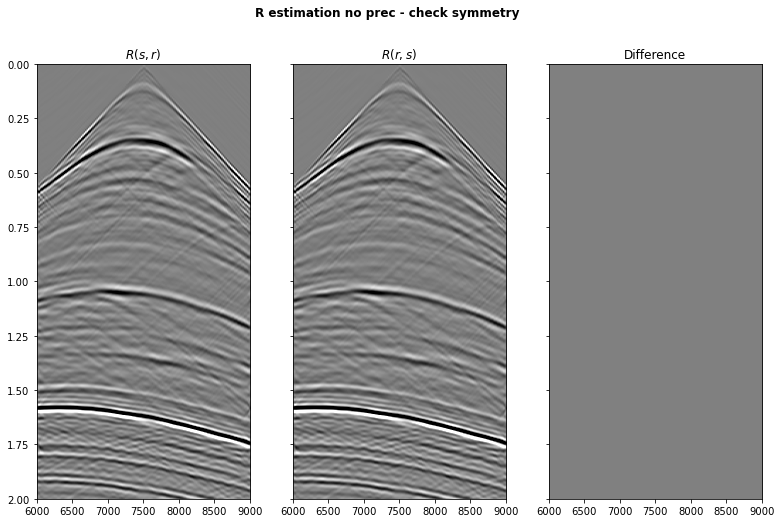

In [9]:
# As R is currently q->vz, transform it into q->p
tracelim = (1e7, -1e7)

rho_sep = 2000
vel_sep = 2766.85
nfftf = ntpad
nfftk = nr
PtoVop = PressureToVelocity(ntpad, nr, dt, dr,
                            rho_sep, vel_sep,
                            nffts=(nfftk, nfftf),
                            critical=100., ntaper=11,
                            topressure=True)           

R = np.hstack([PtoVop * Rorig[:, ir].T.ravel() for ir in range(nr)])
R = np.real(R.reshape(nr, nr, ntpad)).transpose(2, 0, 1)
R = (R + R.transpose(0, 2, 1)) / 2 # enforce reciprocity

clip = 0.1
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(13,8))
axs[0].imshow(Rorig[:, ivs], cmap='gray', vmin=-0.1*np.abs(Rorig).max(), vmax=0.1*np.abs(Rorig).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
axs[0].set_title(r'$R q>vz$')
axs[0].axis('tight')
axs[1].imshow(R[:, ivs], cmap='gray', vmin=-0.1*np.abs(R).max(), vmax=0.1*np.abs(R).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
axs[1].set_title(r'$R q>p$')
axs[1].axis('tight')
axs[2].imshow(R[:, ivs] - Rorig[:, ivs] * rho_sep * vel_sep, cmap='gray', 
              vmin=-0.1*np.abs(R).max(), vmax=0.1*np.abs(R).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
axs[2].set_title(r'Difference')
axs[2].axis('tight')
axs[2].set_ylim(2.5, 0);

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(13,8))
fig.suptitle('R estimation no prec - check symmetry', fontweight='bold')
axs[0].imshow(R[:nt, ivs], cmap='gray', 
              vmin=-clip*np.abs(R).max(), vmax=clip*np.abs(R).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
axs[0].set_title(r'$R(s,r)$')
axs[0].axis('tight')
axs[1].imshow(R[:nt, :, ivs], cmap='gray', 
              vmin=-clip*np.abs(R).max(), vmax=clip*np.abs(R).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
axs[1].set_title(r'$R(r,s)$')
axs[1].axis('tight')
axs[2].imshow(R[:nt, ivs] - R[:nt, :, ivs], cmap='gray', 
              vmin=-clip*np.abs(R).max(), vmax=clip*np.abs(R).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
axs[2].set_title(r'Difference')
axs[2].axis('tight')
axs[2].set_ylim(2., 0);

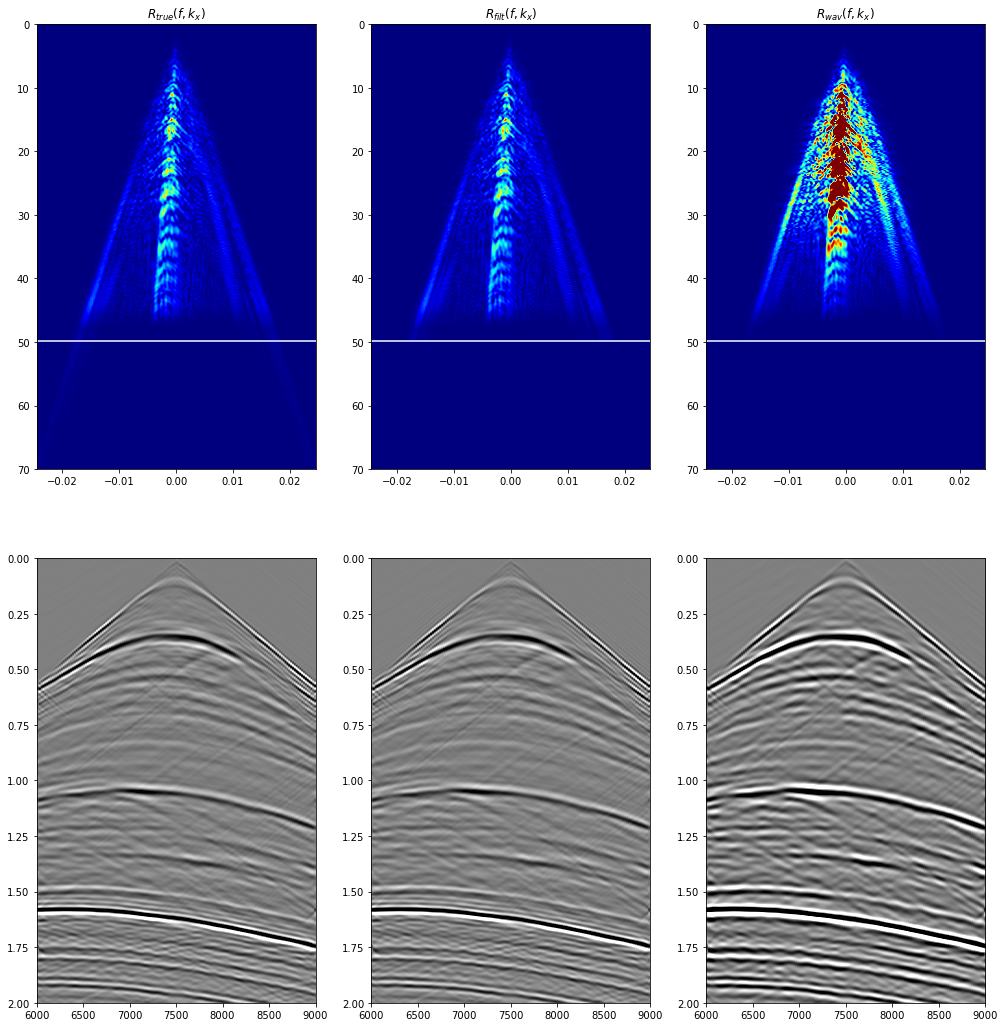

In [10]:
nfmax=400
nfft = ntpad
FFTop = FFT2D(dims=[nr, ntpad], nffts=[nr, nfft], sampling=[dr, dt])
PUP = (FFTop*pup[:, ns//2].T.flatten()).reshape(nr, nfft)
PDOWN = (FFTop*pdown[:, ns//2].T.flatten()).reshape(nr, nfft)

# Filter out high freqs from true response
RTRUE = np.concatenate([(FFTop * R[:, ir].T.ravel()).reshape(1, nr, nfft) for ir in range(nr)], axis=0)
RFILT = RTRUE.copy()
RFILT[:, :, nfmax:-nfmax] = 0
Rfilt = np.concatenate([np.real((FFTop.H * RFILT[ir].ravel()).reshape(1, nr, ntpad)) for ir in range(nr)], axis=0).transpose(2, 0, 1)

# Add wavelet to R
Rfiltwav = np.apply_along_axis(convolve, 0, Rfilt, wav, mode='full')
Rfiltwav = Rfiltwav[wav_c:][:ntpad]
RFILTWAV = np.concatenate([(FFTop * Rfiltwav[:, ir].T.ravel()).reshape(1, nr, nfft) for ir in range(nr)], axis=0)

clip = 0.1
fig, axs = plt.subplots(2, 3, figsize=(17, 18))
axs[0][0].imshow(np.fft.fftshift(np.abs(RTRUE[ivs, :, :nfft//2-1]),axes=0).T, 
                 cmap='jet', interpolation='sinc',
                 extent = (-FFTop.f1[nr//2-1], FFTop.f1[nr//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(RTRUE).max())
axs[0][0].axhline(FFTop.f2[nfmax], color='w')
axs[0][0].set_title(r'$R_{true}(f, k_x)$')
axs[0][0].axis('tight')
axs[0][0].set_ylim(70, 0);           
axs[0][1].imshow(np.fft.fftshift(np.abs(RFILT[ivs, :, :nfft//2-1]),axes=0).T, 
                 cmap='jet', interpolation='sinc',
                 extent = (-FFTop.f1[nr//2-1], FFTop.f1[nr//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(RTRUE).max())
axs[0][1].axhline(FFTop.f2[nfmax], color='w')
axs[0][1].set_title(r'$R_{filt}(f, k_x)$')
axs[0][1].axis('tight')
axs[0][1].set_ylim(70, 0)
axs[0][2].imshow(np.fft.fftshift(np.abs(RFILTWAV[ivs, :, :nfft//2-1]),axes=0).T, 
                 cmap='jet', interpolation='sinc',
                 extent = (-FFTop.f1[nr//2-1], FFTop.f1[nr//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(RTRUE).max())
axs[0][2].axhline(FFTop.f2[nfmax], color='w')
axs[0][2].set_title(r'$R_{wav}(f, k_x)$')
axs[0][2].axis('tight')
axs[0][2].set_ylim(70, 0);           
axs[1][0].imshow(R[:nt, nr//2], cmap='gray', 
                 vmin=-clip*np.abs(R).max(), vmax=clip*np.abs(R).max(),
                 extent = (r[0], r[-1], t[-1], t[0]))
axs[1][0].axis('tight')
axs[1][0].set_ylim(2., 0);
axs[1][1].imshow(Rfilt[:nt, nr//2], cmap='gray', 
                 vmin=-clip*np.abs(R).max(), vmax=clip*np.abs(R).max(),
                 extent = (r[0], r[-1], t[-1], t[0]))
axs[1][1].axis('tight')
axs[1][1].set_ylim(2., 0)
axs[1][2].imshow(Rfiltwav[:nt, nr//2], cmap='gray', 
                 vmin=-clip*np.abs(Rfiltwav).max(), vmax=clip*np.abs(Rfiltwav).max(),
                 extent = (r[0], r[-1], t[-1], t[0]))
axs[1][2].axis('tight')
axs[1][2].set_ylim(2., 0);

In [11]:
#np.savez('Data/mdd_salt_data', t=t, Rfilt=Rfilt[:nt, nr//2], pup=pup[:nt, :, nr//2], pdown=pdown[:nt, :, nr//2], s=s)

## Benchmark MDD

In [12]:
def errnorm(m, mtrue, enorm, enormwin=None):
    if not enormwin:
        mmax = np.abs(m).max() if m.max() != 0 else 1
        mtruemax = np.abs(mtrue).max() if mtrue.max() != 0 else 1
    else:
        mmax = np.abs(m.reshape(mtrue.shape)[enormwin[0]:enormwin[1],enormwin[2]:enormwin[3]]).max() if np.abs(m.reshape(mtrue.shape)[enormwin[0]:enormwin[1],enormwin[2]:enormwin[3]]).max() != 0 else 1
        mtruemax = np.abs(mtrue[enormwin[0]:enormwin[1],enormwin[2]:enormwin[3]]).max() if np.abs(mtrue[enormwin[0]:enormwin[1],enormwin[2]:enormwin[3]]).max() != 0 else 1
    enorm.append(np.linalg.norm(m/mmax - mtrue.ravel()/mtruemax))

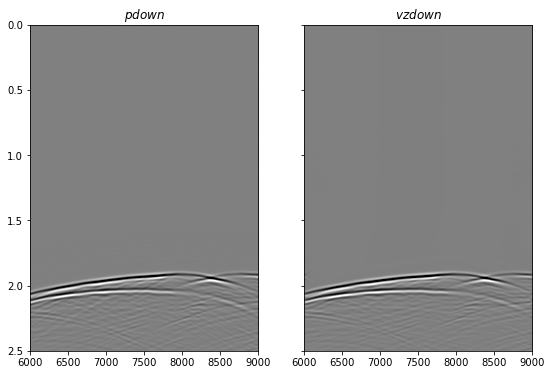

In [13]:
# VZplus from Pplus
rho_sep = 2000
vel_sep = 2766.85
nfftf = ntpad
nfftk = nr
PtoVop = PressureToVelocity(ntpad, nr, dt, dr,
                            rho_sep, vel_sep,
                            nffts=(nfftk, nfftf),
                            critical=100., ntaper=11,
                            topressure=False)           

vzdown = np.hstack([PtoVop * pdown[:, isrc].T.ravel() for isrc in range(ns)])
vzdown = np.real(vzdown.reshape(ns, nr, ntpad)).transpose(2, 0, 1)
vzdown *= 1e7

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(9,6))
axs[0].imshow(pdown[:, ns//2], cmap='gray', vmin=-0.1*np.abs(pdown).max(), vmax=0.1*np.abs(pdown).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
axs[0].set_title(r'$pdown$')
axs[0].axis('tight')
axs[1].imshow(vzdown[:, ns//2], cmap='gray', vmin=-0.1*np.abs(vzdown).max(), vmax=0.1*np.abs(vzdown).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
axs[1].set_title(r'$vzdown$')
axs[1].axis('tight')
axs[1].set_ylim(2.5, 0);

In [14]:
PDOWN = np.fft.rfft(vzdown, ntpad, axis=0)
PDOWN = PDOWN[:nfmax]

MDCop = MDC(PDOWN, nt=ntpad,
            nv=1, dt=dt, dr=dr, 
            twosided=False, transpose=False)
# Adjoint
Radj = MDCop.H * pup[:, :, ivs].ravel()
Radj = np.real(Radj).reshape(ntpad, nr)
   
# No reciprocity prec
errorwin = [70,120,50,100]
Rinv_noprec_error = []
Rinv_noprec, _, _, _, _, Rinv_noprec_res = \
    cgls(MDCop, pup[:, :, ivs].ravel(), niter=niter, 
         x0=np.zeros((ntpad, nr)).ravel(), damp=1e-9, tol=0., show=1,
         callback=lambda x: errnorm(x, Rfilt[..., ivs], Rinv_noprec_error),)
Rinv_noprec = np.real(Rinv_noprec).reshape(ntpad, nr)
Rinv_noprec_res = Rinv_noprec_res**2 / (ntpad * ns)

pupinv_noprec = MDCop * Rinv_noprec.ravel()
pupinv_noprec = pupinv_noprec.reshape(ntpad, ns)

CGLS
-----------------------------------------------------------
The Operator Op has 403206 rows and 302906 cols
damp = 1.000000e-09	tol = 0.000000e+00	niter = 20
-----------------------------------------------------------
    Itn           x[0]              r1norm          r2norm
     1        -3.5404e-06         1.9770e+00      1.9770e+00
     2        -4.2619e-06         1.8516e+00      1.8516e+00
     3        -5.2126e-06         1.8011e+00      1.8011e+00
     4        -6.1844e-06         1.7724e+00      1.7724e+00
     5        -5.9710e-06         1.7513e+00      1.7513e+00
     6        -4.8403e-06         1.7350e+00      1.7350e+00
     7        -3.4140e-06         1.7219e+00      1.7219e+00
     8        -3.0005e-06         1.7105e+00      1.7105e+00
     9        -3.5571e-06         1.7002e+00      1.7002e+00
    10        -3.9683e-06         1.6904e+00      1.6904e+00
    11        -3.9593e-06         1.6813e+00      1.6813e+00
    12        -3.2741e-06         1.6726e+00   

(-0.5, 49.5, 49.5, -0.5)

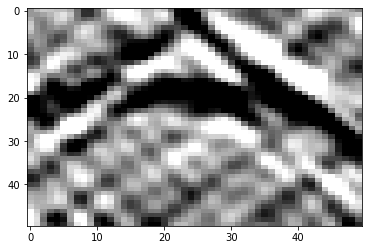

In [15]:
errorwin = [70,120,50,100]
clip=0.1

plt.figure()
plt.imshow(Rinv_noprec[errorwin[0]:errorwin[1],errorwin[2]:errorwin[3]], cmap='gray', 
           vmin=-clip*np.abs(Rinv_noprec).max(), vmax=clip*np.abs(Rinv_noprec).max())
plt.axis('tight')

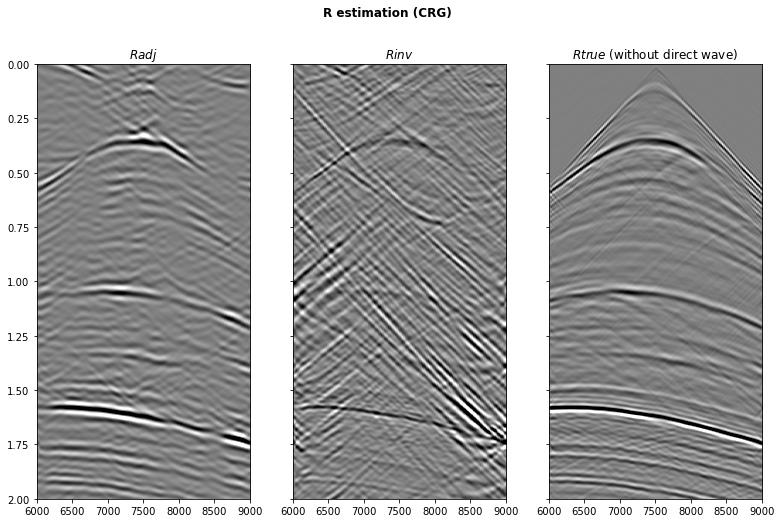

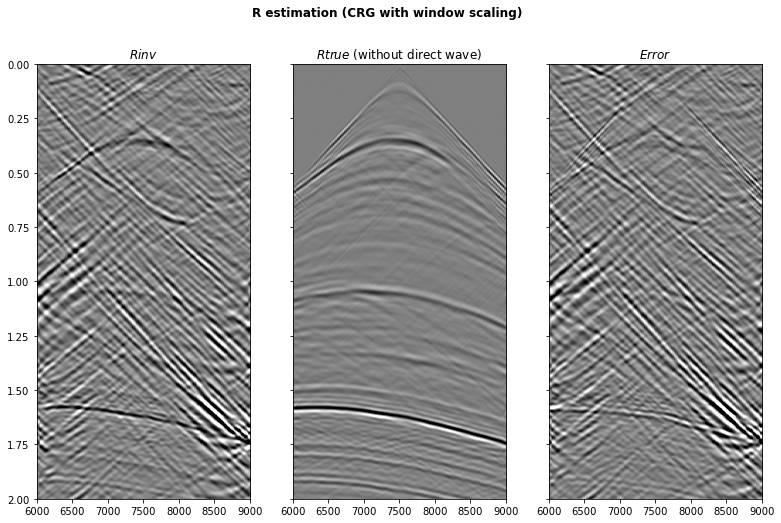

In [16]:
clip = 0.4
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(13, 8))
fig.suptitle('R estimation (CRG)', fontweight='bold')
axs[0].imshow(Radj[:nt], cmap='gray', 
              vmin=-clip*np.abs(Radj).max(), vmax=clip*np.abs(Radj).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
axs[0].set_title(r'$Radj$')
axs[0].axis('tight')
axs[1].imshow(Rinv_noprec[:nt], cmap='gray', 
              vmin=-clip*np.abs(Rinv_noprec).max(), vmax=clip*np.abs(Rinv_noprec).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
axs[1].set_title(r'$Rinv$')
axs[1].axis('tight')
axs[2].imshow(Rfilt[:nt, ivs], cmap='gray',
              vmin=-clip*np.abs(Rfilt[:, ivs]).max(), vmax=clip*np.abs(Rfilt[:, ivs]).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
axs[2].set_title(r'$Rtrue$ (without direct wave)')
axs[2].axis('tight')
axs[2].set_ylim(2., 0);

clip = 0.9
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(13, 8))
fig.suptitle('R estimation (CRG with window scaling)', fontweight='bold')
axs[0].imshow(Rinv_noprec[:nt]/np.abs(Rinv_noprec[errorwin[0]:errorwin[1],errorwin[2]:errorwin[3]]).max(), 
              cmap='gray', vmin=-clip, vmax=clip,
              extent = (r[0], r[-1], t[-1], t[0]))
axs[0].set_title(r'$Rinv$')
axs[0].axis('tight')
axs[1].imshow(Rfilt[:nt, ivs]/np.abs(Rfilt[errorwin[0]:errorwin[1],errorwin[2]:errorwin[3]]).max(), 
              cmap='gray', vmin=-clip, vmax=clip,
              extent = (r[0], r[-1], t[-1], t[0]))
axs[1].set_title(r'$Rtrue$ (without direct wave)')
axs[1].axis('tight')
axs[1].set_ylim(2., 0)
axs[2].imshow(Rinv_noprec[:nt]/np.abs(Rinv_noprec[errorwin[0]:errorwin[1],errorwin[2]:errorwin[3]]).max()-
              Rfilt[:nt, ivs]/np.abs(Rfilt[errorwin[0]:errorwin[1],errorwin[2]:errorwin[3]]).max(), 
              cmap='gray', vmin=-clip, vmax=clip,
              extent = (r[0], r[-1], t[-1], t[0]))
axs[2].set_title(r'$Error$')
axs[2].axis('tight')
axs[2].set_ylim(2., 0);

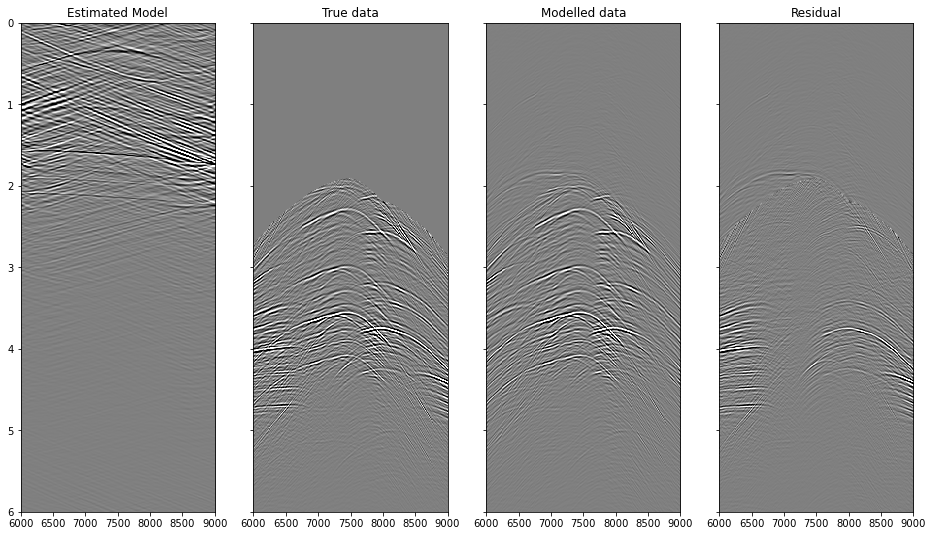

In [17]:
clip = 0.2
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(16, 9))
ax1.imshow(Rinv_noprec[:nt], cmap='gray', 
           vmin=-clip*np.abs(Rinv_noprec).max(), vmax=clip*np.abs(Rinv_noprec).max(),
           extent = (r[0], r[-1], t[-1], t[0]))
ax1.set_title('Estimated Model')
ax1.axis('tight')
ax2.imshow(pup[:nt, :, ivs], aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip*pup[:, :, ivs].max(), vmax=clip*pup[:, :, ivs].max(),
           extent = (r[0], r[-1], t[-1], t[0]))
ax2.set_title('True data')
ax3.imshow(pupinv_noprec[:nt], aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip*pup[:, :, ivs].max(), vmax=clip*pup[:, :, ivs].max(),
           extent = (r[0], r[-1], t[-1], t[0]))
ax3.set_title('Modelled data')
ax4.imshow((pup[:, :, ivs]-pupinv_noprec)[:nt], aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip*pup[:, :, ivs].max(), vmax=clip*pup[:, :, ivs].max(),
           extent = (r[0], r[-1], t[-1], t[0]))
ax4.set_title('Residual')
ax4.set_ylim(6, 0);

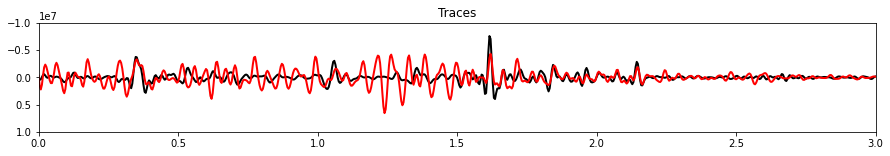

In [18]:
scale = np.abs(Rfilt[:, nr//2, nr//2]).max() / np.abs(Rinv_noprec[:, nr//2]).max()

fig, ax = plt.subplots(1, 1, figsize=(15, 2))
ax.plot(t, Rfilt[:nt, nr//2, nr//2], 'k', lw=2, label='True')
ax.plot(t, Rinv_noprec[jt:nt+jt, nr//2] * scale, 'r', lw=2, label='Inv')
ax.axis('tight')
ax.set_title('Traces')
ax.set_xlim(0, 3)
ax.set_ylim(tracelim[0], tracelim[1]);

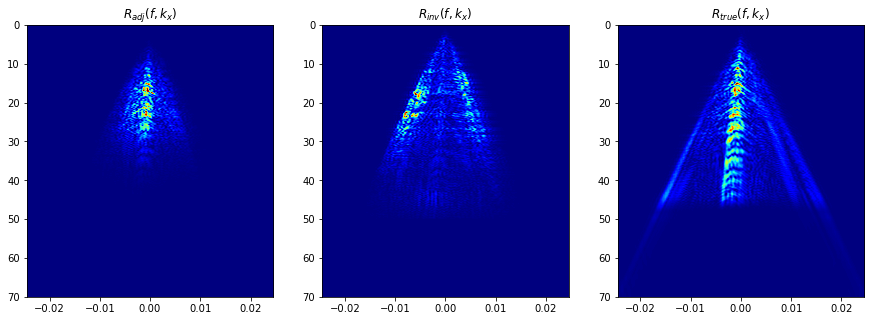

In [19]:
RADJ = (FFTop*Radj.T.ravel()).reshape(nr, nfft)
RINV = (FFTop*Rinv_noprec.T.ravel()).reshape(nr, nfft)
RTRUE = (FFTop*R[..., nr//2].T.ravel()).reshape(nr, nfft)

fig, axs = plt.subplots(1, 3, figsize=(15,5))
im=axs[0].imshow(np.fft.fftshift(np.abs(RADJ[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (-FFTop.f1[nr//2-1], FFTop.f1[nr//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(RADJ).max())
axs[0].axhline(FFTop.f2[2*nfmax], color='w')
axs[0].set_title(r'$R_{adj}(f, k_x)$')
axs[0].axis('tight')
axs[0].set_ylim(70, 0)
im=axs[1].imshow(np.fft.fftshift(np.abs(RINV[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (-FFTop.f1[nr//2-1], FFTop.f1[nr//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(RINV).max())
axs[1].axhline(FFTop.f2[2*nfmax], color='w')
axs[1].set_title(r'$R_{inv}(f, k_x)$')
axs[1].axis('tight')
axs[1].set_ylim(70, 0)
im=axs[2].imshow(np.fft.fftshift(np.abs(RTRUE[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (-FFTop.f1[nr//2-1], FFTop.f1[nr//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(RTRUE).max())
axs[2].axhline(FFTop.f2[2*nfmax], color='w')
axs[2].set_title(r'$R_{true}(f, k_x)$')
axs[2].axis('tight');
axs[2].set_ylim(70, 0);

In [20]:
Rinv_noprec_error

[25.527119063344248,
 25.011169975552427,
 25.698148744689696,
 24.61357626121781,
 24.74662040993157,
 25.398218841979567,
 26.219544823600295,
 27.196279776114164,
 28.293339990374026,
 29.472339767700305,
 30.728249925678174,
 32.0923233191473,
 33.48583915985532,
 34.89165392708046,
 36.296217886478814,
 37.71146208448561,
 39.08906228923923,
 40.31077936273182,
 40.806158833743716,
 41.09915488262113]

# Steepest descent MDD

In [21]:
# analytical stepsize
m0 = np.zeros((ntpad, nr)).ravel()
Rsd, _, alphaana = steepest_descent(MDCop.H @ MDCop, MDCop.H @ pup[:, :, ivs].ravel(), 
                                    niter=niter, m0=m0, a=None, tol=1e-3, savemhist=False)
Rsd = np.real(Rsd).reshape(ntpad, nr)

pupsd = MDCop * Rsd.ravel()
pupsd = pupsd.reshape(ntpad, ns)

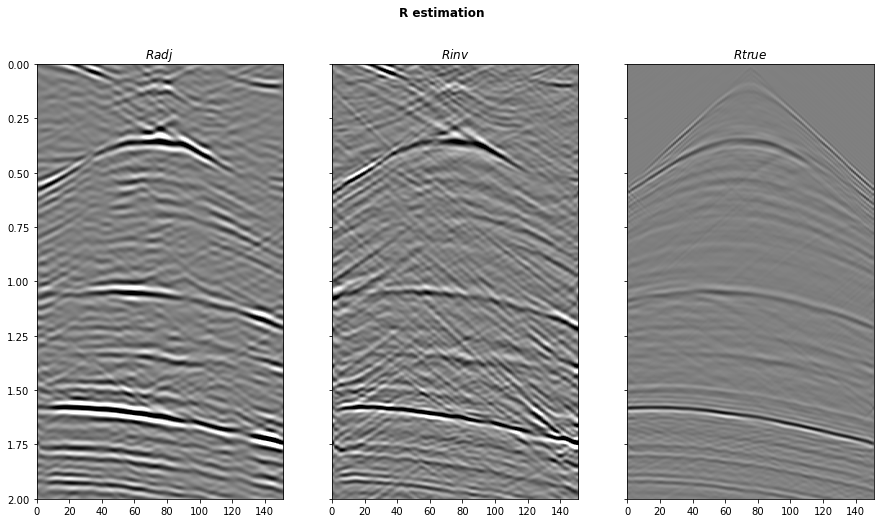

In [22]:
clip = 0.3
itmax = 2000
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 8))
fig.suptitle('R estimation', fontweight='bold')
axs[0].imshow(Radj[:nt], cmap='gray', 
              vmin=-clip*np.abs(Radj).max(), vmax=clip*np.abs(Radj).max(),
              extent = (0, nr, t[itmax], 0))
axs[0].set_title(r'$Radj$')
axs[0].axis('tight')
axs[1].imshow(Rsd[:nt], cmap='gray', 
              vmin=-clip*np.abs(Rsd).max(), vmax=clip*np.abs(Rsd).max(),
              extent = (0, nr, t[itmax], 0))
axs[1].set_title(r'$Rinv$')
axs[1].axis('tight')
axs[2].imshow(Rfilt[:nt, ivs], cmap='gray',
              vmin=-clip*np.abs(Rfilt).max(), vmax=clip*np.abs(Rfilt).max(),
              extent = (0, nr, t[itmax], 0))
axs[2].set_title(r'$Rtrue$')
axs[2].axis('tight')
axs[2].set_ylim(2., 0);

Estimate the eigenvalues of the operator

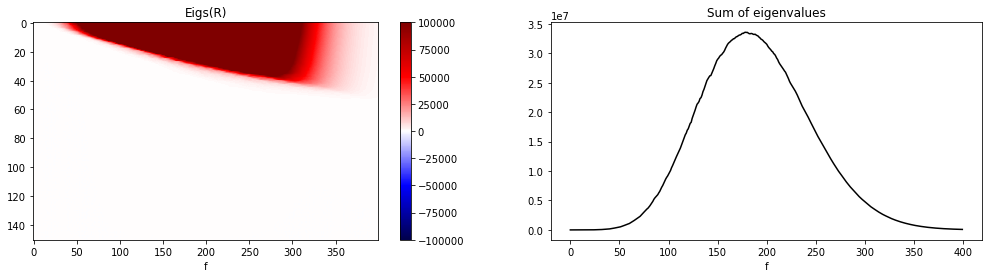

In [23]:
# Directly on the operator
eigmax = (MDCop.H @ MDCop).eigs(neigs=1)

# On the kernel of the operator
PDOWN = dt * dr * np.sqrt(ntpad) * np.fft.rfft(vzdown, ntpad, axis=0)
PDOWN = PDOWN[:nfmax]
eigs = np.linalg.eig(np.matmul(np.conj(PDOWN.transpose(0,2,1)), PDOWN))[0]
eigs = np.fliplr(np.sort(np.abs(eigs), axis=1))

fig, axs = plt.subplots(1, 2, figsize=(17, 4))
im = axs[0].imshow(eigs.T, cmap='seismic', vmin=-1e5, vmax=1e5)
axs[0].set_title('Eigs(R)')
axs[0].set_xlabel('f')
axs[0].axis('tight')
plt.colorbar(im, ax=axs[0])
axs[1].plot(np.sum(eigs, axis=1), 'k')
axs[1].set_title('Sum of eigenvalues')
axs[1].set_xlabel('f');

9.8932339133031e-07 9.893233913303105e-07


array([7.47353377e-07, 9.48913440e-07, 8.99252077e-07, 1.02640548e-06,
       9.33399324e-07, 1.04796636e-06, 9.42157955e-07, 1.05322464e-06,
       9.43964010e-07, 1.05383618e-06, 9.43735087e-07, 1.05306786e-06,
       9.42921441e-07, 1.05194666e-06, 9.42000196e-07, 1.05081837e-06,
       9.41130187e-07, 1.04979153e-06, 9.40355065e-07, 1.04888796e-06])

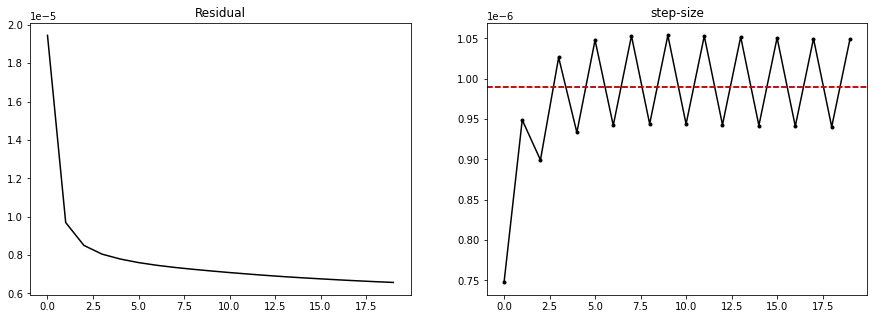

In [24]:
alphamax1 = 2. / eigs.max() 
alphamax = 2. / np.real(eigmax[0])
print(alphamax1, alphamax)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(Rinv_noprec_res, 'k')
axs[0].set_title('Residual')
axs[1].plot(alphaana, '.-k')
axs[1].axhline(alphamax, c='k', linestyle='--')
axs[1].axhline(alphamax1, c='r', linestyle='--')
axs[1].set_title('step-size');

alphaana

In [25]:
# fixed stepsize inversion
alphamax = 1.9 / np.real(eigmax[0])
m0 = np.zeros((ntpad, nr)).ravel()
Rsd, _, alphaana = steepest_descent(MDCop.H @ MDCop, MDCop.H @ pup[:, :, ivs].ravel(), 
                                    niter=niter, m0=m0, a=alphamax, tol=1e-3, savemhist=False)
Rsd = np.real(Rsd).reshape(ntpad, nr)

pupsd = MDCop * Rsd.ravel()
pupsd = pupsd.reshape(ntpad, ns)

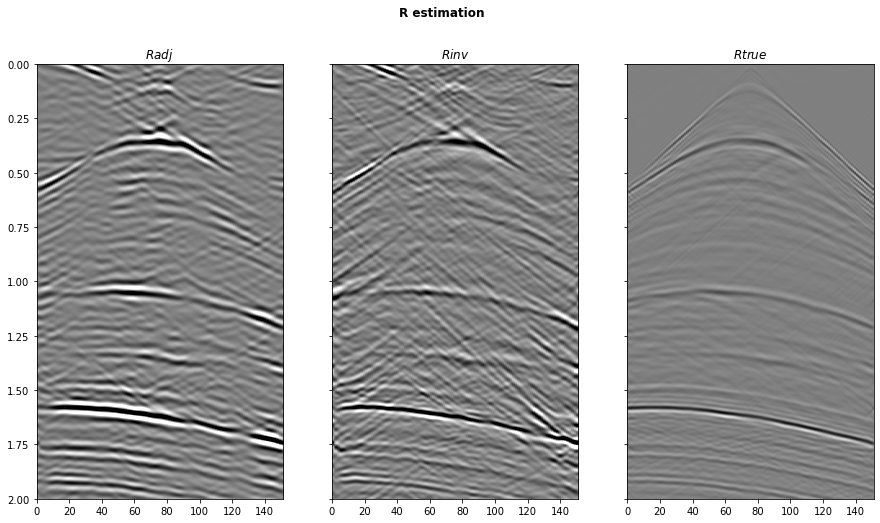

In [26]:
clip = 0.3
itmax = 2000
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 8))
fig.suptitle('R estimation', fontweight='bold')
axs[0].imshow(Radj[:nt], cmap='gray', 
              vmin=-clip*np.abs(Radj).max(), vmax=clip*np.abs(Radj).max(),
              extent = (0, nr, t[itmax], 0))
axs[0].set_title(r'$Radj$')
axs[0].axis('tight')
axs[1].imshow(Rsd[:nt], cmap='gray', 
              vmin=-clip*np.abs(Rsd).max(), vmax=clip*np.abs(Rsd).max(),
              extent = (0, nr, t[itmax], 0))
axs[1].set_title(r'$Rinv$')
axs[1].axis('tight')
axs[2].imshow(Rfilt[:nt, ivs], cmap='gray',
              vmin=-clip*np.abs(Rfilt).max(), vmax=clip*np.abs(Rfilt).max(),
              extent = (0, nr, t[itmax], 0))
axs[2].set_title(r'$Rtrue$')
axs[2].axis('tight')
axs[2].set_ylim(2., 0);

## Stochastic MDD

In [27]:
# Identify learning-rate based on steepest descent first step / analytical upper bound.
# To make it equivalent to analytic steepest descent, denominator compensates for 
# different norm used in torch which is normalized by number of elements
lrstmax = alphamax # from steepest descent notebook
lrstmax * ((nt*ns)/2)

0.18900575722531004

In [28]:
no_of_batches= int(np.ceil(ns/batch_size))
lossdict = {}
avgdict = {}
lossepochdict = {}
enormdict = {}
mdict = {}

In [29]:
PDOWN = np.fft.rfft(vzdown, ntpad, axis=0)
PDOWN = PDOWN[:nfmax]

R = torch.from_numpy(R)
Rfilt = torch.from_numpy(Rfilt)
PDOWN = torch.from_numpy(PDOWN)
pup = torch.from_numpy(pup[..., ivs])

### SGD

In [30]:
lr = {}
lr[21] = 0.01
lr[32] = 0.01 # 0.08
lr[64] = 0.01

model, dmod, lossdict['SGD'], avgdict['SGD'], lossepochdict['SGD'], enormdict['SGD'], _ = \
                 MDDminibatch(ntpad, nr, dt, dr, PDOWN, pup, torch.optim.SGD, 
                              nepochs, batch_size, twosided=False, mtrue=Rfilt[..., ivs], seed=0, epochprint=5,
                              enormabsscaling=True,
                              **dict(lr=lr[batch_size], weight_decay=0))
mdict["SGD"] = model.detach().numpy()

Initial Gradient norm: 3.150201e-04, scaled by lr: 3.150201e-08
Initial Gradient norm as np.linalg.norm: 5.696657e+02, scaled by nbatches:  3.578212e+03
epoch:   5, loss : 9.7800e-06, loss avg : 9.2543e-06
epoch:  10, loss : 1.1790e-05, loss avg : 8.7552e-06
epoch:  15, loss : 8.2678e-06, loss avg : 8.1273e-06
epoch:  20, loss : 4.3365e-06, loss avg : 7.5853e-06
Final Model norm: 5.542014e-06
Time: 13.967165 s


In [31]:
# First loss 
np.sum(np.abs(pup.view(-1).numpy())**2) / (len(pup.view(-1))), lossepochdict['SGD'][0], Rinv_noprec_res[0]

(1.9453023791017193e-05, 1.9453023791017193e-05, 1.945302379101719e-05)

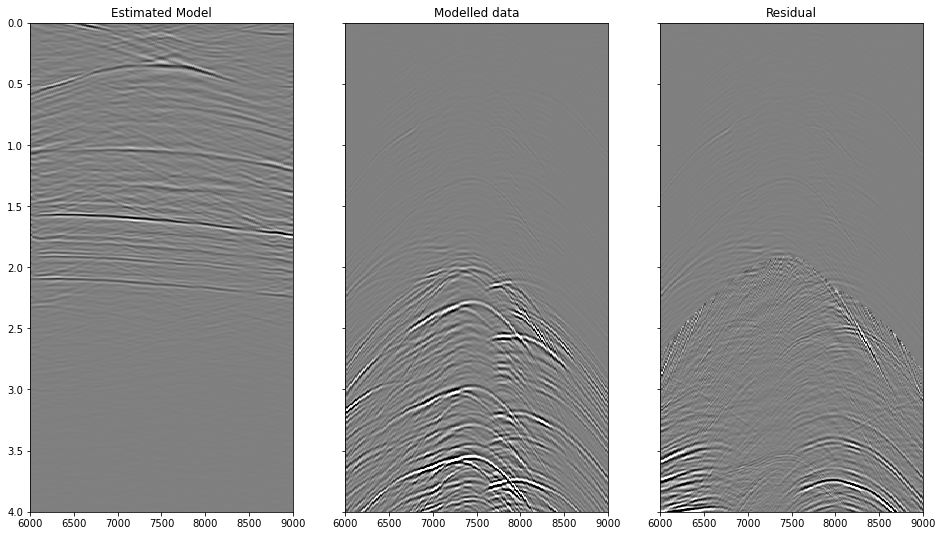

In [33]:
clip = 0.2
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(16, 9))
ax1.imshow(model.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-6e-5, vmax=6e-5,
           extent = (r[0], r[-1], t[-1], t[0]))
ax1.set_title('Estimated Model')
ax2.imshow(dmod.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip*pup.detach().numpy().max(), vmax=clip*pup.detach().numpy().max(),
           extent = (r[0], r[-1], t[-1], t[0]))
ax2.set_title('Modelled data')
ax3.imshow((dmod-pup).detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip*pup.detach().numpy().max(), vmax=clip*pup.detach().numpy().max(),
           extent = (r[0], r[-1], t[-1], t[0]))
ax3.set_title('Residual')
ax3.set_ylim(4, 0);

### SGD with momentum

In [34]:
lr = {}
lr[21] = 0.004
lr[32] = 0.004
lr[64] = 0.004

model, dmod, lossdict['SGDMom'], avgdict['SGDMom'], lossepochdict['SGDMom'], enormdict['SGDMom'], _ = \
                 MDDminibatch(ntpad, nr, dt, dr, PDOWN, pup, torch.optim.SGD, 
                              nepochs, batch_size, twosided=False, mtrue=Rfilt[..., ivs], seed=0, epochprint=5,
                              enormabsscaling=True,
                              **dict(lr=lr[batch_size], weight_decay=1e-4, momentum=0.8, nesterov=True))
mdict["SGDMom"] = model.detach().numpy()

Initial Gradient norm: 3.150201e-04, scaled by lr: 5.040321e-09
Initial Gradient norm as np.linalg.norm: 5.696657e+02, scaled by nbatches:  3.578212e+03
epoch:   5, loss : 9.4784e-06, loss avg : 8.5683e-06
epoch:  10, loss : 1.1689e-05, loss avg : 8.4501e-06
epoch:  15, loss : 8.0638e-06, loss avg : 7.8604e-06
epoch:  20, loss : 4.1849e-06, loss avg : 7.3511e-06
Final Model norm: 7.334527e-06
Time: 14.428720 s


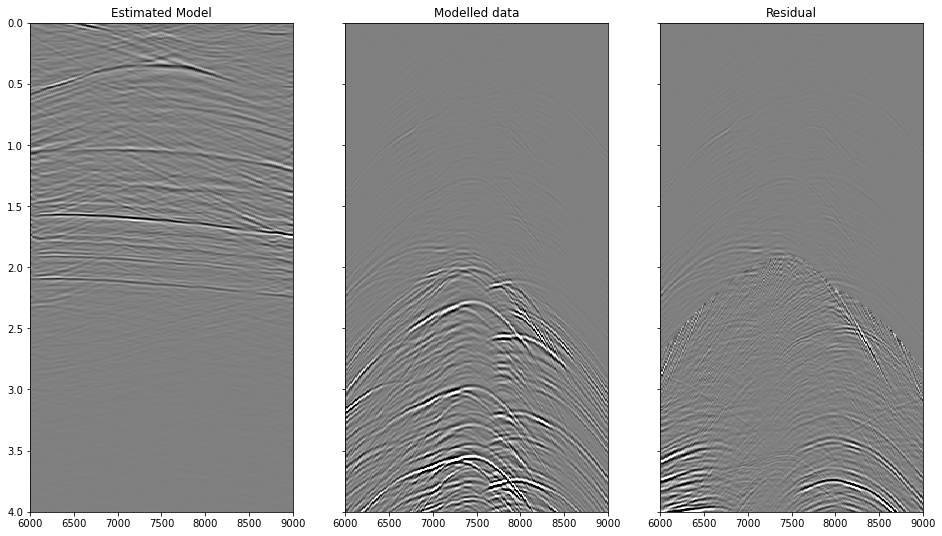

In [35]:
clip = 0.2
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(16, 9))
ax1.imshow(model.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-6e-5, vmax=6e-5,
           extent = (r[0], r[-1], t[-1], t[0]))
ax1.set_title('Estimated Model')
ax2.imshow(dmod.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip*pup.detach().numpy().max(), vmax=clip*pup.detach().numpy().max(),
           extent = (r[0], r[-1], t[-1], t[0]))
ax2.set_title('Modelled data')
ax3.imshow((dmod-pup).detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip*pup.detach().numpy().max(), vmax=clip*pup.detach().numpy().max(),
           extent = (r[0], r[-1], t[-1], t[0]))
ax3.set_title('Residual')
ax3.set_ylim(4, 0);

### SGD with momentum and exponential LR

In [36]:
lr = {}
lr[21] = 0.01
lr[32] = 0.01
lr[64] = 0.01

model, dmod, lossdict['SGDMom_LRexp'], avgdict['SGDMom_LRexp'], lossepochdict['SGDMom_LRexp'], enormdict['SGDMom_LRexp'], lr = \
                 MDDminibatch(ntpad, nr, dt, dr, PDOWN, pup, torch.optim.SGD, 
                              nepochs, batch_size, twosided=False, mtrue=Rfilt[..., ivs], seed=0,
                              scheduler=torch.optim.lr_scheduler.ExponentialLR, epochprint=5,
                              enormabsscaling=True,
                              kwargs_sched=dict(gamma=0.97, last_epoch=-1, verbose=False),
                              **dict(lr=lr[batch_size], weight_decay=1e-4, momentum=0.8, nesterov=True))
                 
mdict["SGDMom_LRexp"] = model.detach().numpy()

Initial Gradient norm: 3.150201e-04, scaled by lr: 3.150201e-08
Initial Gradient norm as np.linalg.norm: 5.696657e+02, scaled by nbatches:  3.578212e+03
epoch:   5, loss : 9.3003e-06, loss avg : 8.2988e-06
epoch:  10, loss : 1.1241e-05, loss avg : 8.2069e-06
epoch:  15, loss : 7.6946e-06, loss avg : 7.7442e-06
epoch:  20, loss : 3.9236e-06, loss avg : 7.3209e-06
Final Model norm: 5.819903e-06
Time: 14.141473 s


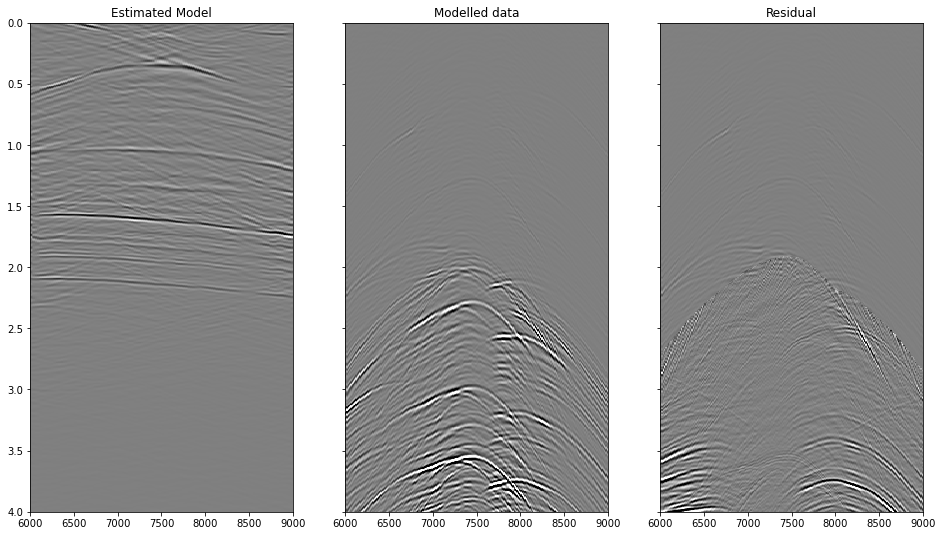

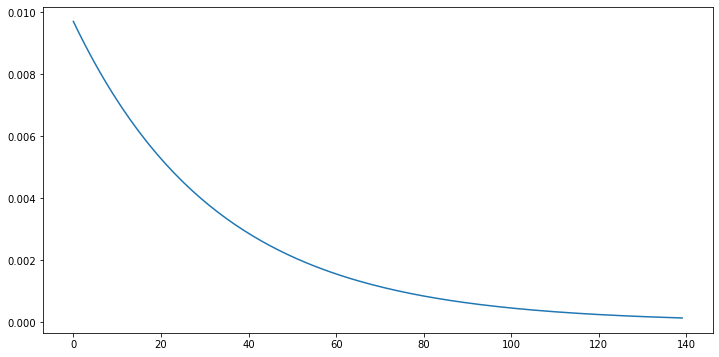

In [37]:
clip = 0.2
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(16, 9))
ax1.imshow(model.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-6e-5, vmax=6e-5,
           extent = (r[0], r[-1], t[-1], t[0]))
ax1.set_title('Estimated Model')
ax2.imshow(dmod.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip*pup.detach().numpy().max(), vmax=clip*pup.detach().numpy().max(),
           extent = (r[0], r[-1], t[-1], t[0]))
ax2.set_title('Modelled data')
ax3.imshow((dmod-pup).detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip*pup.detach().numpy().max(), vmax=clip*pup.detach().numpy().max(),
           extent = (r[0], r[-1], t[-1], t[0]))
ax3.set_title('Residual')
ax3.set_ylim(4, 0);

fig = plt.figure(figsize= (12,6))
plt.plot(lr);

## Comparison

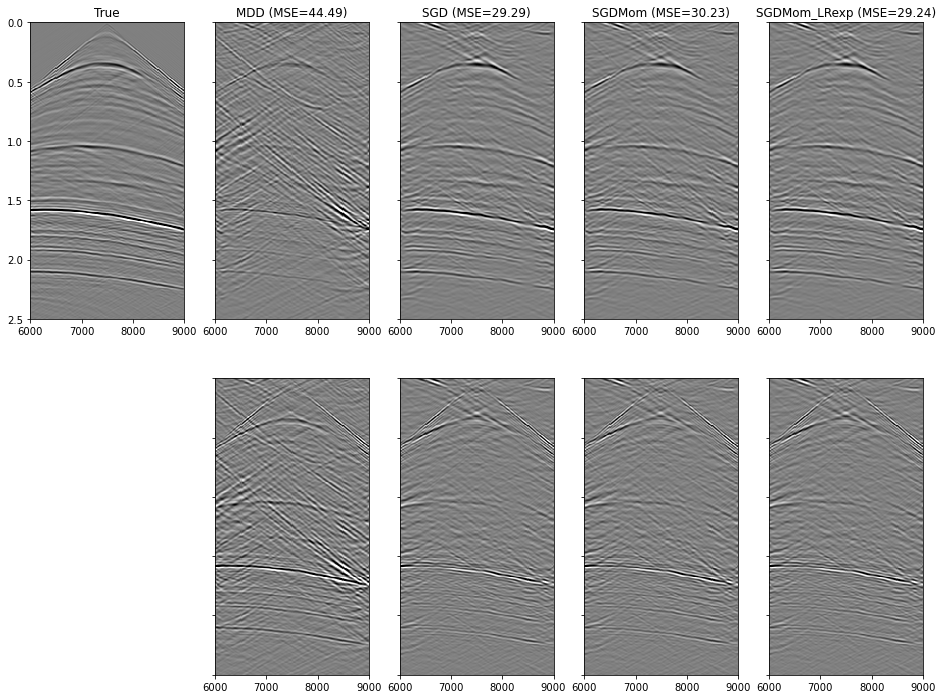

In [39]:
# Normalized by max
clip = 0.6

fig, axs = plt.subplots(2, len(mdict)+2, sharey=True, figsize=(16, 12))
axs[0][0].imshow(Rfilt[:nt, ivs]/Rfilt[:nt, ivs].max(), aspect='auto', interpolation='nearest', cmap='gray',
                 vmin=-clip, vmax=clip,
                 extent = (r[0], r[-1], t[-1], t[0]))
axs[0][0].axis('tight')
axs[0][0].set_title('True')
axs[0][1].imshow(Rinv_noprec[:nt]/Rinv_noprec[:nt].max(), aspect='auto', interpolation='nearest', cmap='gray',
                 vmin=-clip, vmax=clip,
                 extent = (r[0], r[-1], t[-1], t[0]))
axs[0][1].axis('tight')
axs[0][1].set_title('MDD (MSE=%.2f)' % np.linalg.norm(Rfilt[:nt, ivs]/Rfilt[:nt, ivs].max()-
                                                      Rinv_noprec[:nt]/Rinv_noprec[:nt].max()))

for iloss, loss in enumerate(mdict.keys()):
    axs[0][iloss+2].imshow(mdict[loss][:nt]/mdict[loss][:nt].max(), aspect='auto', interpolation='nearest', cmap='gray',
                           vmin=-clip, vmax=clip,
                           extent = (r[0], r[-1], t[-1], t[0]))
    axs[0][iloss+2].axis('tight')
    axs[0][iloss+2].set_title('%s (MSE=%.2f)' % 
                              (loss, np.linalg.norm(Rfilt[:nt, ivs]/Rfilt[:nt, ivs].max()-mdict[loss][:nt]/mdict[loss][:nt].max())))
axs[0][-1].set_ylim(2.5, 0)

axs[1][0].axis('off')
axs[1][1].imshow(Rfilt[:nt, ivs]/Rfilt[:nt, ivs].max()-Rinv_noprec[:nt]/Rinv_noprec[:nt].max(), 
                 aspect='auto', interpolation='nearest', cmap='gray',
                 vmin=-clip, vmax=clip,
                 extent = (r[0], r[-1], t[-1], t[0]))
axs[1][1].axis('tight')

for iloss, loss in enumerate(mdict.keys()):
    axs[1][iloss+2].imshow(Rfilt[:nt, ivs]/Rfilt[:nt, ivs].max()-mdict[loss][:nt]/mdict[loss][:nt].max(), 
                           aspect='auto', interpolation='nearest', cmap='gray',
                           vmin=-clip, vmax=clip,
                           extent = (r[0], r[-1], t[-1], t[0]))
    axs[1][iloss+2].axis('tight')
axs[1][-1].set_ylim(2.5, 0);

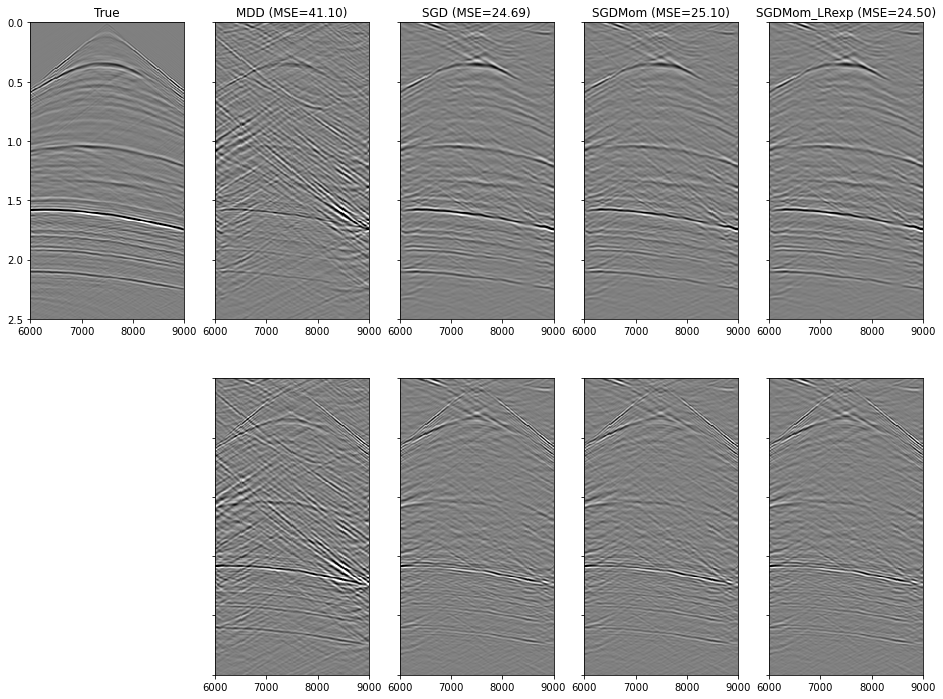

In [40]:
# Normalized by abs max
clip = 0.6

fig, axs = plt.subplots(2, len(mdict)+2, sharey=True, figsize=(16, 12))
axs[0][0].imshow(Rfilt[:nt, ivs]/np.abs(Rfilt[:nt, ivs]).max(), 
                 aspect='auto', interpolation='nearest', cmap='gray',
                 vmin=-clip, vmax=clip,
                 extent = (r[0], r[-1], t[-1], t[0]))
axs[0][0].axis('tight')
axs[0][0].set_title('True')
axs[0][1].imshow(Rinv_noprec[:nt]/np.abs(Rinv_noprec[:nt]).max(), 
                 aspect='auto', interpolation='nearest', cmap='gray',
                 vmin=-clip, vmax=clip,
                 extent = (r[0], r[-1], t[-1], t[0]))
axs[0][1].axis('tight')
axs[0][1].set_title('MDD (MSE=%.2f)' % np.linalg.norm(Rfilt[:, ivs]/np.abs(Rfilt[:, ivs]).max()-
                                                      Rinv_noprec[:]/np.abs(Rinv_noprec[:]).max()))

for iloss, loss in enumerate(mdict.keys()):
    axs[0][iloss+2].imshow(mdict[loss][:nt]/np.abs(mdict[loss][:nt]).max(), 
                           aspect='auto', interpolation='nearest', cmap='gray',
                           vmin=-clip, vmax=clip,
                           extent = (r[0], r[-1], t[-1], t[0]))
    axs[0][iloss+2].axis('tight')
    axs[0][iloss+2].set_title('%s (MSE=%.2f)' % 
                              (loss, np.linalg.norm(Rfilt[:, ivs]/np.abs(Rfilt[:, ivs]).max()-
                                                    mdict[loss][:]/np.abs(mdict[loss][:]).max())))
axs[0][-1].set_ylim(2.5, 0)

axs[1][0].axis('off')
axs[1][1].imshow(Rfilt[:nt, ivs]/np.abs(Rfilt[:nt, ivs]).max()-
                 Rinv_noprec[:nt]/np.abs(Rinv_noprec[:nt]).max(), 
                 aspect='auto', interpolation='nearest', cmap='gray',
                 vmin=-clip, vmax=clip,
                 extent = (r[0], r[-1], t[-1], t[0]))
axs[1][1].axis('tight')

for iloss, loss in enumerate(mdict.keys()):
    axs[1][iloss+2].imshow(Rfilt[:nt, ivs]/np.abs(Rfilt[:nt, ivs]).max()-
                           mdict[loss][:nt]/np.abs(mdict[loss][:nt]).max(), 
                           aspect='auto', interpolation='nearest', cmap='gray',
                           vmin=-clip, vmax=clip,
                           extent = (r[0], r[-1], t[-1], t[0]))
    axs[1][iloss+2].axis('tight')
axs[1][-1].set_ylim(2.5, 0);

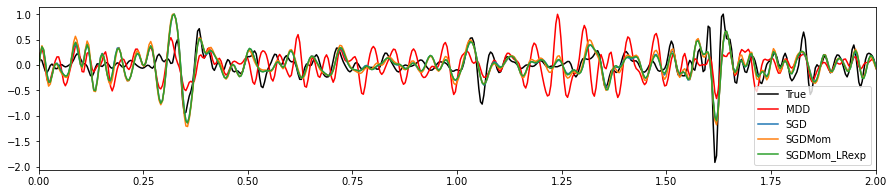

In [41]:
plt.figure(figsize=(15, 3))
plt.plot(t, Rfilt[:nt, nr//2, nr//2] / Rfilt[:nt, nr//2, nr//2].max(), 'k', label='True')
plt.plot(t, Rinv_noprec[:nt, nr//2] / Rinv_noprec[:nt, nr//2].max(), 'r', label='MDD')
for iloss, loss in enumerate(mdict.keys()):
    plt.plot(t, mdict[loss][:nt, nr//2]/mdict[loss][:nt, nr//2].max(), label=loss)
plt.legend()
plt.xlim(0, 2.);

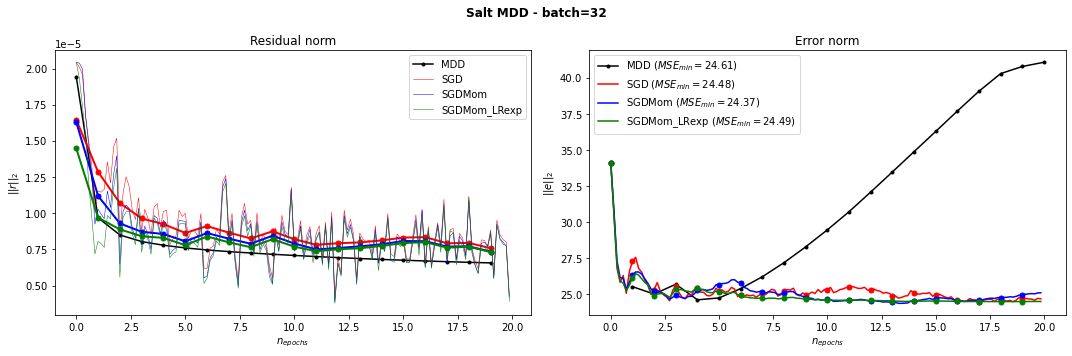

In [43]:
colors = ('r', 'b', 'g')

fig, axs = plt.subplots(1, 2, figsize= (15,5))
fig.suptitle('Salt MDD - batch=%d' %batch_size, fontweight='bold')
axs[0].plot(np.arange(nepochs), Rinv_noprec_res[:nepochs], '.-k', label="MDD")
for loss, avg, color in zip(lossdict.keys(), avgdict.keys(), colors):
    axs[0].plot((np.arange(0, no_of_batches*nepochs, no_of_batches))/no_of_batches, avgdict[avg], 
                '.-%s' % color, ms=10, linewidth = 2)
    axs[0].plot(np.arange(len(lossdict[loss]))/no_of_batches , lossdict[loss], '%s' % color, label = loss, lw=0.5)
axs[0].set_xlabel(r'$n_{epochs}$')
axs[0].set_ylabel(r'$||r||_2$')
axs[0].set_title("Residual norm")
axs[0].legend()

axs[1].plot(np.arange(nepochs)+1, Rinv_noprec_error[:nepochs], '.-k', 
            label=r"MDD ($MSE_{min}=%.2f)$" % np.array(Rinv_noprec_error[:nepochs]).min())
for enorm, color in zip(enormdict.keys(), colors):
    axs[1].plot(np.arange(len(enormdict[enorm]))/no_of_batches, enormdict[enorm], 
                '%s' % color, ms=10, label=r"%s ($MSE_{min}=%.2f)$" % (enorm, np.array(enormdict[enorm]).min()))
    axs[1].plot((np.arange(len(enormdict[enorm]))/no_of_batches)[::no_of_batches], enormdict[enorm][::no_of_batches],
                '.%s' % color, ms=10, linewidth = 2)
axs[1].set_xlabel(r'$n_{epochs}$')
axs[1].set_ylabel(r'$||e||_2$')
axs[1].set_title("Error norm")
axs[1].legend()
fig.tight_layout();

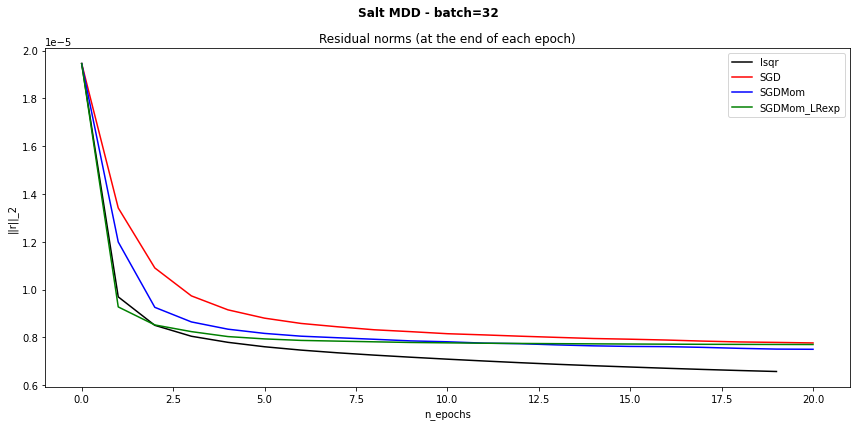

In [44]:
colors = ('r', 'b', 'g')

fig = plt.figure(figsize= (12,6))
fig.suptitle('Salt MDD - batch=%d' %batch_size, fontweight='bold')
plt.plot(np.arange(nepochs), Rinv_noprec_res[:nepochs], 'k', label='lsqr')
for loss, color in zip(lossdict.keys(), colors):
    if loss != 'Page':
        plt.plot(np.arange(nepochs+1), lossepochdict[loss], color, label = str(loss).split()[0])
plt.xlabel('n_epochs')
plt.ylabel('||r||_2')
plt.title('Residual norms (at the end of each epoch)')
plt.legend()
plt.tight_layout();